In [1]:
from __future__ import print_function, division, absolute_import

import os

%matplotlib inline
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
import astropy.io.ascii as at
import astropy.io.fits as fits
import astropy.units as u
from astropy.time import Time
from cycler import cycler
from matplotlib.patches import Rectangle

from hypra.utils import cat_io
from emissionline import emissionline

home_dir = os.getenv("HOME")

In [2]:
matplotlib.rc("axes",#prop_cycle=cycler('color',cm.Dark2(np.linspace(0,1,8))),
             labelsize=14)
matplotlib.rc("font",size=14)

In [3]:
pdat,_,_,_ = cat_io.get_data("P")

K2 C16 ran from 2017-12-07 23:01:18 to 2017-12-11 07:27:11 UTC

In [4]:
name = "HSHJ272"
np.where(pdat["LITNAME"]==name)[0]
epic = pdat["EPIC_ID"][pdat["LITNAME"]==name][0]
# epic = # 211966619=JS706
print(epic)

211971468


In [5]:
lcfile = os.path.expanduser("~/Dropbox/K2/k2sc_C16/EPIC_{0}_mast.fits".format(epic))
os.path.exists(lcfile)

True

In [6]:
def k2sc_io(filename):
    """ Read in a K2SC light curve file, and return the time and flux.

    Flux is calculated as the completely detrended flux plus the
    time-dependent trend (i.e., only the position-dependent trend is removed),
    and then normalized.

    Inputs
    ------
    filename: string
        a valid K2SC file, including full or relative path

    Returns:
    --------
    time, flux, white: arrays

    """
    
    trend_t, trend_p, flux, time = "trtime", "trposi", "flux", "time"
    with fits.open(filename) as hdu:
#         print(hdu.info())

        tabl = hdu[1].data
#         print(tabl.dtype)
        good = np.isfinite(tabl[flux]) & (np.isfinite(tabl[trend_t]))
#         print(len(np.where(good)[0]))
        med_trend = np.median(tabl[trend_p][good])
        # https://archive.stsci.edu/kepler/manuals/archive_manual.pdf Page 13
        time = Time(tabl[time][good]+2454833.0, scale='tcg', format="jd")
        flux_out = tabl[flux][good] - (tabl[trend_p][good] - med_trend)

    return time,flux_out

In [7]:
lct,lcf = k2sc_io(lcfile)
print(lct[0])

2458095.488282115


In [8]:
def read_mdm(filename,to_plot=False):
    with fits.open(filename) as spec:
#             print(spec.info())
#             print(spec[0].data)
        
            flux = spec[0].data[0][0]

            w0 = np.float(spec[0].header["CRVAL1"])
            wi = np.int(spec[0].header["CRPIX1"])
            wstep = np.float(spec[0].header["CD1_1"])
            w00 = (0-wi)*wstep + w0
            lf = len(flux)
            wavelength = np.arange(w00,w00+(lf-1)*wstep,wstep)
            while len(wavelength)<lf:
                wavelength = np.append(wavelength,
                                       wavelength[-1]+wstep)

            var = spec[0].data[3][0]
#             print(len(wavelength), len(flux), len(var))

#             print("sec(z) =",spec[0].header["AIRMASS"],
#                   "HA =",spec[0].header["HA"])
            
            if to_plot is True:
                plt.figure(figsize=(10,7))
                for i in range(4):
                    plt.plot(wavelength,spec[0].data[i][0],
                             label="row {0}".format(i))
                    plt.yscale("log")
                    plt.ylim(1e-16,1e-12)
                    plt.xlim(6000,8000)
                    plt.legend(loc="best")
            
#             print(spec[0].header["DATE-OBS"]+" "+spec[0].header["TIME-OBS"])
            tstart = spec[0].header["DATE-OBS"]+" "+spec[0].header["TIME-OBS"]
#             thalf = TimeDelta(spec[0].header["EXPTIME"]/2, format='sec')
#             exp_center = tstart + thalf
                    
    return wavelength, flux, var, tstart# exp_center

In [9]:
w,f,v,t = read_mdm(os.path.expanduser("~/Dropbox/data/MDM_reduced/20180113/finals/trim.{0}.fits".format(name)))

In [10]:
tday = np.append(["01-{0}".format(i) for i in np.arange(11,29)],
                 ["02-0{0}".format(i) for i in np.arange(4,10)])


def make_timeseries(objname):
    
    ew = np.zeros(len(tday))*np.nan
    ewe = np.zeros(len(tday))*np.nan
    t = []
    
    for i,day in enumerate(tday):
#         print(day)
        fname = os.path.expanduser("~/Dropbox/data/MDM_reduced/2018{0}/finals/trim.{1}.fits".format(day.replace("-",""),name))
        if os.path.exists(fname) is False:
            fname = fname.replace(".fits","_comb.fits")
        if os.path.exists(fname) is True:
            w,f,v,tval = read_mdm(fname)
            t.append(tval)
            ew[i], ewe[i], _, _ = emissionline(w, f, v, 
                                           6545, 6550, 
                                           6570, 6575,
                                           6555, 6570)
            
        else:
            t.append("2018-{0} 08:00:00".format(day))
            continue
            
    t = Time(t,format="iso",scale="utc")
    return t, ew, ewe

In [11]:
tt, ew, ewe = make_timeseries(name)

In [12]:
tt.plot_date

array([736705.33333333, 736706.33333333, 736708.30335172, 736708.33333333,
       736710.36891929, 736711.38198485, 736712.33855721, 736713.29574799,
       736714.3687078 , 736714.33333333, 736715.33333333, 736716.33333333,
       736717.33333333, 736718.33333333, 736719.33333333, 736720.33333333,
       736721.33333333, 736722.33333333, 736730.32707409, 736731.36552977,
       736732.38328847, 736733.34951933, 736734.25802032, 736735.36166036])

In [19]:
def plot_time_series(name,epic):
    
    spt = pdat["ADAMSPT"][pdat["LITNAME"]==name][0][:2]
    
    tt, ew, ewe = make_timeseries(name)
    lcfile = os.path.expanduser("~/Dropbox/K2/k2sc_C16/EPIC_{0}_mast.fits".format(epic))
    lct,lcf = k2sc_io(lcfile)

    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10,5))

    axes[0].plot(lct.plot_date,lcf/np.median(lcf),'.',alpha=0.5,color="k")
#     axes[0].set_ylim(np.percentile(lcf/np.median(lcf),0.05),
#                     np.percentile(lcf/np.median(lcf),99))
    axes[0].set_ylabel("K2 Relative Flux")

    for td in tt.plot_date[np.isfinite(ew)]:
        axes[0].axvline(td,ls="--",color="C1",zorder=-11,
                       alpha=0.75)

    axes[1].errorbar(tt.plot_date,ew*-1,
                     ewe,linewidth=0,
                    elinewidth=1.5,color="C1")
    axes[1].plot_date(tt.plot_date,ew*-1,'o',color="C1")
    # print(ew/np.median(ew))

    axes[1].set_xlim(lct[0].plot_date,lct[-1].plot_date)
    axes[1].set_ylabel(r"H$\alpha$ Equivalent Width")
    axes[1].set_xlabel("UTC Date")
    
    wiyn_start = Time("2017-12-12 01:42:31",format="iso",scale="utc")
    wiyn_end = Time("2017-12-19 13:12:17",format="iso",scale="utc")
    wiyn_run = wiyn_end-wiyn_start
    wiyn_mid = wiyn_start+wiyn_run/2
#     print(wiyn_run, ymax-ymin)
    for i in [0,1]:
        ymin, ymax = axes[i].get_ylim()

        wiyn = Rectangle(xy=[wiyn_start.plot_date,ymin],
                         width=wiyn_run.value,
                         height=ymax-ymin,
                         alpha=0.25,color="C3",zorder=-1)
        axes[i].add_patch(wiyn)

        if i==1:
            axes[i].text(wiyn_mid.plot_date,ymin+0.1,
                         "WIYN",horizontalalignment="center",
                         verticalalignment="top",
                        fontsize=14,color="C3")
            if ymin<0:
                axes[i].axhline(0,color="grey",linestyle=":")
            axes[i].set_ylim(ymax,ymin)

    axes[0].set_title("{0} | EPIC {1} ({2})".format(name,epic,spt),
                     fontsize=14)
    plt.savefig(os.path.expanduser("~/Dropbox/talks/hypra figs/halpha_lc_{0}.pdf".format(name)),
                bbox_inches="tight")

In [14]:
wiyn_start = Time("2017-12-12 01:42:31",format="iso",scale="utc")
wiyn_end = Time("2017-12-19 13:12:17",format="iso",scale="utc")
wiyn_run = wiyn_end-wiyn_start

type(wiyn_run)

astropy.time.core.TimeDelta

In [324]:
name = "JC143" #"HSHJ272"
epic = pdat["EPIC_ID"][pdat["LITNAME"]==name][0]
# epic = # 211966619=JS706
print(epic)

211953944


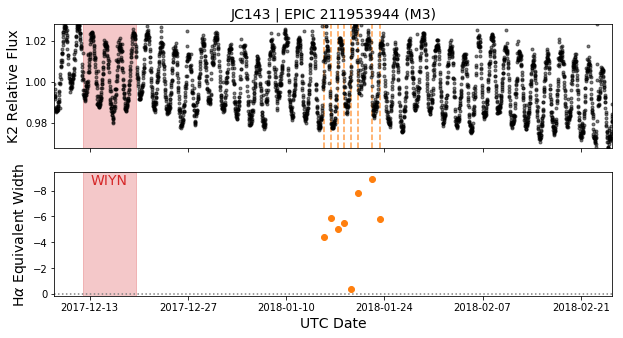

In [325]:
plot_time_series(name,epic)

In [17]:
name = "JS315" #"HSHJ272"
epic = pdat["EPIC_ID"][pdat["LITNAME"]==name][0]
# epic = # 211966619=JS706
print(epic)

211916718


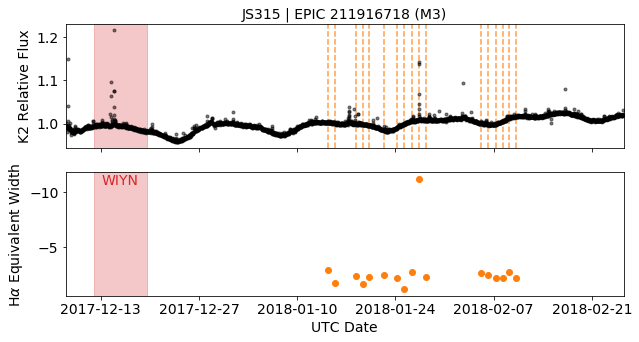

In [20]:
plot_time_series(name,epic)
# plt.xlim(736705,736720)

In [21]:
name = "KW563" 
epic = pdat["EPIC_ID"][pdat["LITNAME"]==name][0]
# epic = # 211966619=JS706
print(epic)

211970427


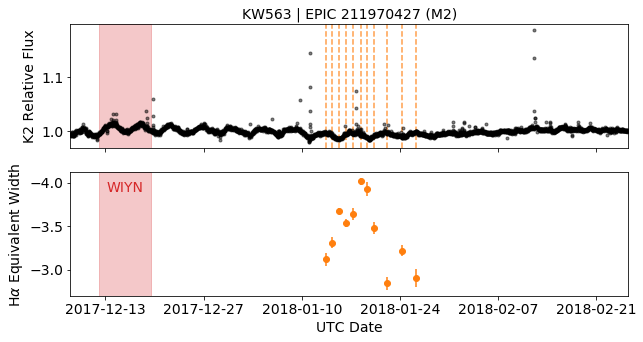

In [22]:
plot_time_series(name,epic)

211949049


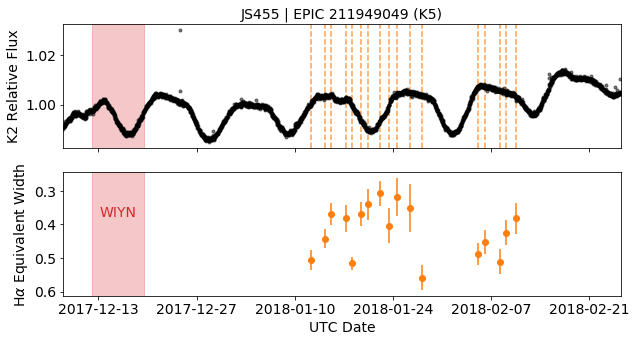

In [23]:
name = "JS455" #"HSHJ272"
epic = pdat["EPIC_ID"][pdat["LITNAME"]==name][0]
# epic = # 211966619=JS706
print(epic)
plot_time_series(name,epic)

211822797


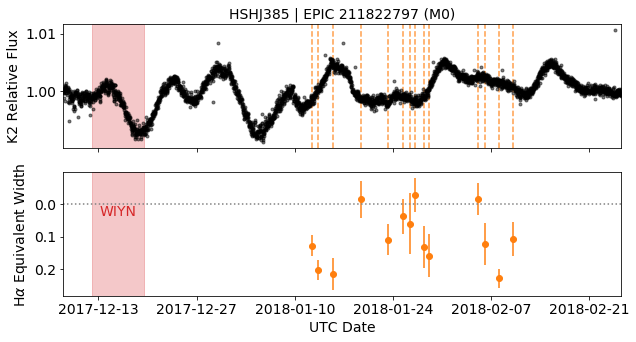

In [24]:
name = "HSHJ385" #"HSHJ272"
epic = pdat["EPIC_ID"][pdat["LITNAME"]==name][0]
# epic = # 211966619=JS706
print(epic)
plot_time_series(name,epic)